In [13]:
#Linear Model

from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# To Mount Google Drive
drive.mount('/content/drive')

# To Load data
df = pd.read_excel('/content/drive/My Drive/BeAmazed/XY_train.xlsx')

# Convert time duration to seconds
def time_to_seconds(time_obj):
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second

# Convert the 'Average view duration' column to seconds
df['Average view duration'] = df['Average view duration'].apply(time_to_seconds)

# Define features
feature_columns = ['Shares', 'Comments added', 'Likes (vs. dislikes) (%)',
                  'Average view duration', 'Subscribers', 'Impressions click-through rate (%)']

# Features and target
X = df[feature_columns]
y = df['Views']

# Train model
model = LinearRegression()
model.fit(X, y)

# To Load and prepare test data
test_df = pd.read_excel('/content/drive/My Drive/BeAmazed/X_test.xlsx')
test_df['Average view duration'] = test_df['Average view duration'].apply(time_to_seconds)

# Select only the feature columns for prediction
X_test = test_df[feature_columns]

# Make predictions
predictions = model.predict(X_test)

# Print model performance metrics
print("\nModel Coefficients (importance of each feature):")
for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef:.2f}")

print("\nFirst 5 predictions:")
print(predictions[:5])

# To Save predictions to Excel
prediction_df = pd.DataFrame({
    'Predicted Views': predictions.astype(int)
})
prediction_df.to_excel('/content/drive/My Drive/BeAmazed/predictions.xlsx', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Model Coefficients (importance of each feature):
Shares: 40.80
Comments added: 320.92
Likes (vs. dislikes) (%): -155911.19
Average view duration: 522.65
Subscribers: 191.18
Impressions click-through rate (%): 156186.93

First 5 predictions:
[9118081.58887727 1716089.28515322 4328705.17845842 2594615.20931954
 3894347.47946424]


In [5]:
#Random Forest

from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import random


# Mount Google Drive
drive.mount('/content/drive')

# Load and prepare data
train_df = pd.read_excel('/content/drive/My Drive/BeAmazed/XY_train.xlsx')
test_df = pd.read_excel('/content/drive/My Drive/BeAmazed/X_test.xlsx')

def convert_time_to_seconds(time_obj):
    # Direct conversion from time object to seconds
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second

train_df['Average view duration'] = train_df['Average view duration'].apply(convert_time_to_seconds)
test_df['Average view duration'] = test_df['Average view duration'].apply(convert_time_to_seconds)

features = ['Shares', 'Comments added', 'Likes (vs. dislikes) (%)',
           'Average view duration', 'Subscribers', 'Impressions click-through rate (%)']

X = train_df[features]
y = train_df['Views']
X_test = test_df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Hill Climbing for RF hyperparameter optimization
def evaluate_rf_params(params, X, y):
    rf = RandomForestRegressor(**params, random_state=42)
    scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
    return scores.mean()

def hill_climbing_optimization(X, y, max_iterations=50):
    current_params = {
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 2,  # Minimum value is 2
        'min_samples_leaf': 1
    }

    current_score = evaluate_rf_params(current_params, X, y)

    for _ in range(max_iterations):
        # Generate neighbor by modifying one parameter
        neighbor_params = current_params.copy()
        param_to_modify = random.choice(list(current_params.keys()))

        if param_to_modify == 'n_estimators':
            neighbor_params[param_to_modify] = max(10, current_params[param_to_modify] +
                                                 random.choice([-20, 20]))
        elif param_to_modify == 'max_depth':
            neighbor_params[param_to_modify] = max(3, current_params[param_to_modify] +
                                                 random.choice([-2, 2]))
        elif param_to_modify == 'min_samples_split':
            # Ensure min_samples_split stays >= 2
            neighbor_params[param_to_modify] = max(2, current_params[param_to_modify] +
                                                 random.choice([-1, 1]))
        else:
            # min_samples_leaf
            neighbor_params[param_to_modify] = max(1, current_params[param_to_modify] +
                                                 random.choice([-1, 1]))

        neighbor_score = evaluate_rf_params(neighbor_params, X, y)

        if neighbor_score > current_score:
            current_params = neighbor_params
            current_score = neighbor_score

    return current_params

# Iterative Local Search
def iterative_local_search(X, y, num_iterations=5):
    best_params = None
    best_score = float('-inf')

    for _ in range(num_iterations):
        # Perform hill climbing from a random starting point
        initial_params = {
            'n_estimators': random.randint(50, 200),
            'max_depth': random.randint(5, 20),
            'min_samples_split': random.randint(2, 5),  # Minimum value is 2
            'min_samples_leaf': random.randint(1, 4)
        }

        current_params = hill_climbing_optimization(X, y)
        current_score = evaluate_rf_params(current_params, X, y)

        if current_score > best_score:
            best_params = current_params
            best_score = current_score

    print(f"Iteration score: {best_score}")  # Added for debugging
    return best_params

# Perform optimization
print("Starting hyperparameter optimization...")
best_params = iterative_local_search(X_scaled, y)
print("\nBest parameters found:", best_params)

# Train final model with optimized parameters
final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_scaled, y)

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Generate and evaluate predictions
predictions = final_model.predict(X_test_scaled)
results_df = pd.DataFrame({
    'Predicted_Views': predictions.round(0)
})

print("\nPrediction Summary Statistics:")
print(results_df.describe())

# Save predictions
results_df.to_excel('/content/drive/My Drive/BeAmazed/rf_predictions_optimized.xlsx', index=False)

# Calculate and display performance metrics
train_predictions = final_model.predict(X_scaled)
train_r2 = r2_score(y, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y, train_predictions))

print("\nModel Performance Metrics:")
print(f"Training R² Score: {train_r2:.4f}")
#XGBoostprint(f"Training RMSE: {train_rmse:.2f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting hyperparameter optimization...
Iteration score: 0.7512114579868638

Best parameters found: {'n_estimators': 40, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}

Feature Importance:
                              feature  importance
4                         Subscribers    0.919723
1                      Comments added    0.036594
0                              Shares    0.017702
3               Average view duration    0.014233
2            Likes (vs. dislikes) (%)    0.006370
5  Impressions click-through rate (%)    0.005377

Prediction Summary Statistics:
       Predicted_Views
count     7.100000e+01
mean      3.699363e+06
std       2.603845e+06
min       1.448761e+06
25%       1.717938e+06
50%       2.844989e+06
75%       4.468908e+06
max       1.612555e+07

Model Performance Metrics:
Training R² Score: 0.9040
Training RMSE: 997558.4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[0]	validation_0-rmse:2987403.27943
[1]	validation_0-rmse:2820589.25268
[2]	validation_0-rmse:2606069.10317
[3]	validation_0-rmse:2426180.51934
[4]	validation_0-rmse:2260753.98300
[5]	validation_0-rmse:2120435.19386
[6]	validation_0-rmse:1983625.46509
[7]	validation_0-rmse:1887446.30116
[8]	validation_0-rmse:1770790.09137
[9]	validation_0-rmse:1672334.54251
[10]	validation_0-rmse:1569336.40637
[11]	validation_0-rmse:1498499.23088
[12]	validation_0-rmse:1425585.36726
[13]	validation_0-rmse:1376024.21027
[14]	validation_0-rmse:1300047.35300
[15]	validation_0-rmse:1263225.57905
[16]	validation_0-rmse:1211489.56173
[17]	validation_0-rmse:1149874.56792
[18]	validation_0-rmse:1099191.11913
[19]	validation_0-rmse:1055844.86327
[20]	validation_0-rmse:1018060.90177
[21]	validation_0-rmse:982600.40974
[22]	validation_0-rmse:947779.43261
[23]	validation_0-rmse:923023.86

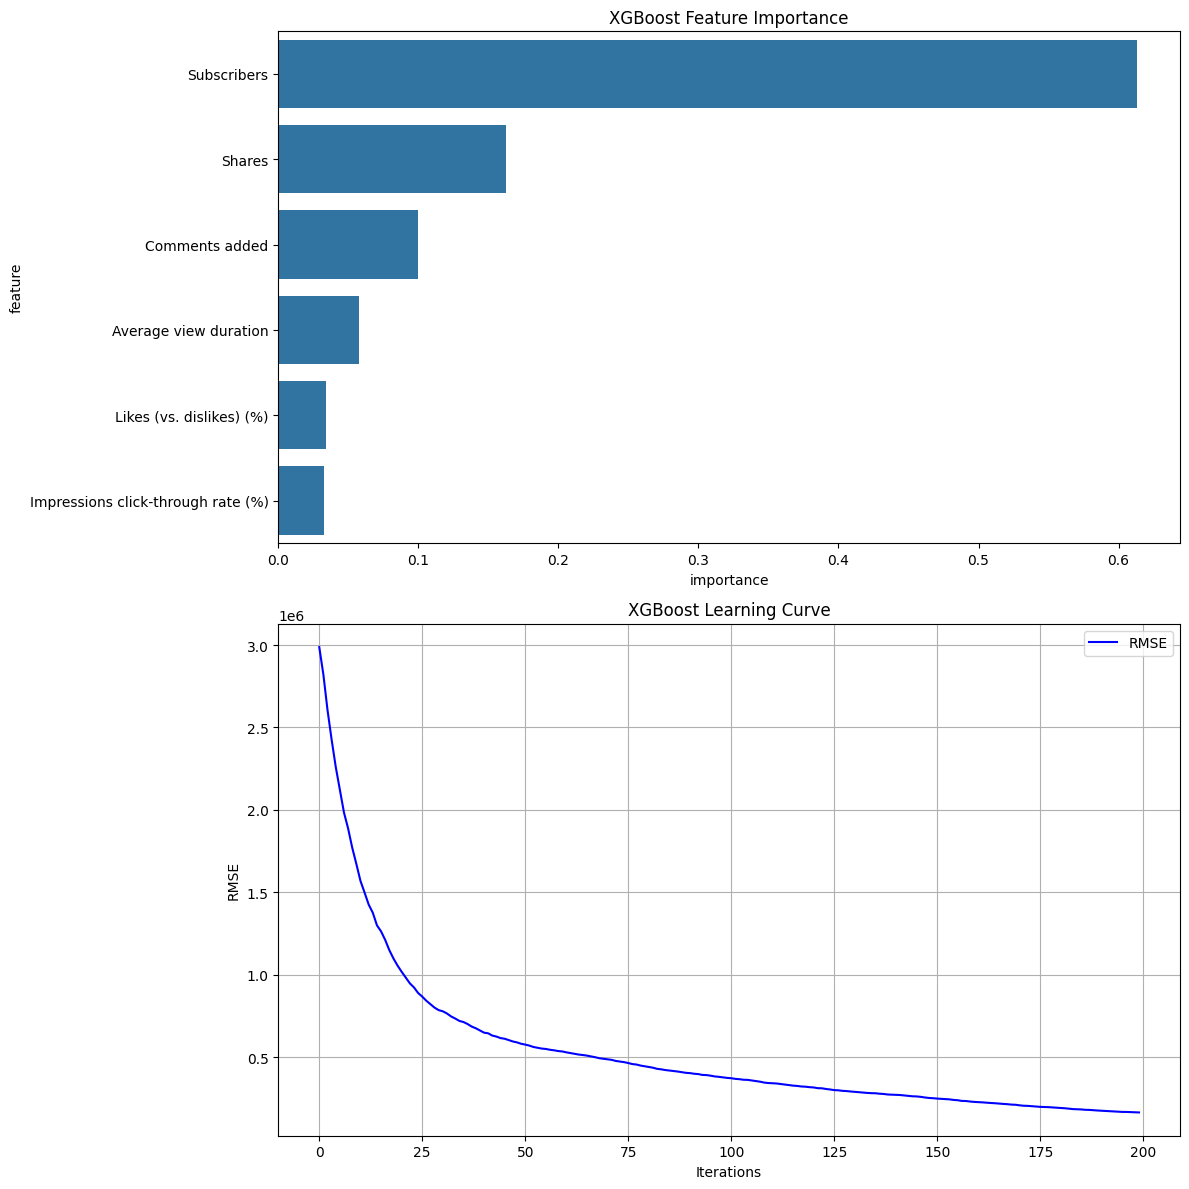


Prediction Summary for New Videos:
* Average predicted views: 3,681,310.75
* Typical (median) views: 3,053,477.00
* Lowest prediction: 1,138,200.00
* Highest prediction: 14,113,367.00
* Variation in predictions: ±2,530,234.25

Confidence in Predictions:
1. Model accuracy: 99.7375%
2. Average prediction error: ±164,921.68 views
3. Most predictions will fall between:
   - At least 1,817,894.50 views (low end)
   - Up to 4,591,270.00 views (high end)


In [12]:

#XGBoost

from google.colab import drive
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Drive and load data
drive.mount('/content/drive')

# To Load data
train_df = pd.read_excel('/content/drive/My Drive/BeAmazed/XY_train.xlsx')
test_df = pd.read_excel('/content/drive/My Drive/BeAmazed/X_test.xlsx')

# Convert time duration to seconds
def time_to_seconds(time_obj):
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second

train_df['Average view duration'] = train_df['Average view duration'].apply(time_to_seconds)
test_df['Average view duration'] = test_df['Average view duration'].apply(time_to_seconds)

# Prepare features
features = ['Shares', 'Comments added', 'Likes (vs. dislikes) (%)',
           'Average view duration', 'Subscribers', 'Impressions click-through rate (%)']

X = train_df[features]
y = train_df['Views']
X_test = test_df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': 42,
    'eval_metric': 'rmse'  # Moved eval_metric here
}

# Create and train model
xgb_model = xgb.XGBRegressor(**xgb_params)
eval_set = [(X_scaled, y)]
xgb_model.fit(X_scaled, y, eval_set=eval_set, verbose=True)

# Store the evaluation results
results = {'validation_0': {'rmse': []}}
for i in range(xgb_model.n_estimators):
    pred = xgb_model.predict(X_scaled, iteration_range=(0, i + 1))
    rmse = np.sqrt(mean_squared_error(y, pred))
    results['validation_0']['rmse'].append(rmse)

# Get predictions
xgb_predictions = xgb_model.predict(X_test_scaled)
train_predictions = xgb_model.predict(X_scaled)

# Calculate performance metrics
train_r2 = r2_score(y, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y, train_predictions))

print("\nXGBoost Performance Metrics:")
print(f"Training R² Score: {train_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f}")

# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# To Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: Feature Importance
sns.barplot(x='importance', y='feature', data=feature_importance, ax=ax1)
ax1.set_title('XGBoost Feature Importance')

# Plot 2: Learning Curve
validation_scores = results['validation_0']['rmse']
iterations = range(len(validation_scores))
ax2.plot(iterations, validation_scores, 'b-', label='RMSE')
ax2.set_title('XGBoost Learning Curve')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('RMSE')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Calculate prediction summary statistics
predictions_summary = pd.DataFrame({
    'Predicted_Views': xgb_predictions.round(0)
}).describe()

print("\nPrediction Summary for New Videos:")
print(f"* Average predicted views: {predictions_summary['Predicted_Views']['mean']:,.2f}")
print(f"* Typical (median) views: {predictions_summary['Predicted_Views']['50%']:,.2f}")
print(f"* Lowest prediction: {predictions_summary['Predicted_Views']['min']:,.2f}")
print(f"* Highest prediction: {predictions_summary['Predicted_Views']['max']:,.2f}")
print(f"* Variation in predictions: ±{predictions_summary['Predicted_Views']['std']:,.2f}")

print("\nConfidence in Predictions:")
print(f"1. Model accuracy: {train_r2:.4%}")
print(f"2. Average prediction error: ±{train_rmse:,.2f} views")
print("3. Most predictions will fall between:")
print(f"   - At least {predictions_summary['Predicted_Views']['25%']:,.2f} views (low end)")
print(f"   - Up to {predictions_summary['Predicted_Views']['75%']:,.2f} views (high end)")

# To Save predictions
results_df = pd.DataFrame({
    'Predicted_Views': xgb_predictions.round(0)
})
results_df.to_excel('/content/drive/My Drive/BeAmazed/xgboost_predictions.xlsx', index=False)